<a href="https://colab.research.google.com/github/emBykov/Rice_Image_Datase/blob/main/DS_project_rice_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data loading

In [ ]:
import os
import gdown
import zipfile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
                             precision_recall_curve, average_precision_score)
from sklearn.preprocessing import label_binarize

In [ ]:
class GoogleDataDownloader:
    def __init__(self, zip_file_id, zip_file_name):
        self.zip_file_id = zip_file_id
        self.zip_file_name = zip_file_name
        self.data_folder = 'rice_data'
        self.data_path = os.path.join(self.data_folder, self.zip_file_name)
        self.data_subfolders = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
        self.download_zip()

        example_image_path = os.path.join(self.data_path, self.data_subfolders[0], 'Arborio (1).jpg')
        with Image.open(example_image_path) as img:
            width, height = img.size
            print(f"Original image resolution: {width} x {height}")

    def download_zip(self):
        if not os.path.exists(self.data_folder):
            url = f'https://drive.google.com/uc?id={self.zip_file_id}'
            gdown.download(url, 'rice_data.zip', quiet=False)
            with zipfile.ZipFile('rice_data.zip', 'r') as zip_ref:
                zip_ref.extractall(self.data_folder)
            os.remove('rice_data.zip')

In [ ]:
def plot_images(data_path, data_subfolders, n=3):
    images_by_class = {label: [] for label in data_subfolders}
    for label in data_subfolders:
        subfolder = os.path.join(data_path, label)
        count = 0
        for file in os.listdir(subfolder):
            if count >= n:
                break
            if file.endswith('.jpg'):
                img_path = os.path.join(subfolder, file)
                images_by_class[label].append(Image.open(img_path))
                count += 1

    plt.figure(figsize=(8, 6))
    for row in range(n):
        for col, label in enumerate(data_subfolders):
            idx = row * len(data_subfolders) + col
            plt.subplot(n, 5, idx + 1)
            plt.imshow(images_by_class[label][row])
            plt.title(label)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_pie_chart(data_subfolders):
    names = data_subfolders
    size_of_groups=[1,1,1,1,1]


    fig, ax = plt.subplots()
    ax.pie(size_of_groups, labels=names, autopct='%1.1f%%')
    plt.show()

In [ ]:
file_id = '17Xsswk-_-C-N0BilUjs8S_q5DMHp8PT_'

In [ ]:
downloader = GoogleDataDownloader(zip_file_id=file_id, zip_file_name='Rice_Image_Dataset')

Original image resolution: 250 x 250


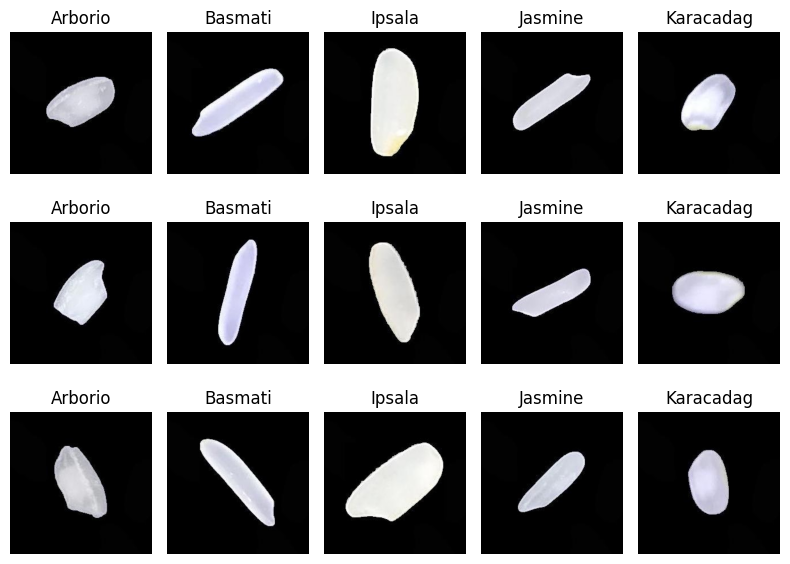

In [ ]:
plot_images(downloader.data_path,downloader.data_subfolders, n=3)

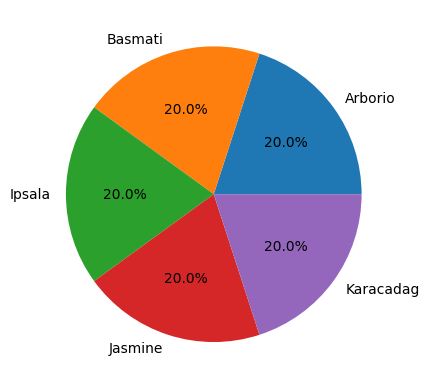

In [ ]:
plot_pie_chart(downloader.data_subfolders)

# Preprocessing and feature engineering

Download x and y if they are not in colab directory yet

In [ ]:
if not (os.path.exists('x.pkl') and os.path.exists('y.pkl')):
    print('downloading x, y')
    x_file_id = '1NpvTC0snzcMi_dl5YpkhSIO0nGhklrfO'
    y_file_id = '1KYbUQroUL8hesBeeNOE0Ktfaf4cXGSqF'
    url = f'https://drive.google.com/uc?id={x_file_id}'
    gdown.download(url, 'x.pkl', quiet=False)
    url = f'https://drive.google.com/uc?id={y_file_id}'
    gdown.download(url, 'y.pkl', quiet=False)

In [ ]:
class ImageLoader:
    def __init__(self, folder_path, labels, images_per_class=15000, resize=(32,32)):
        self.folder_path = folder_path
        self.labels = labels
        self.images_per_class = images_per_class
        self.num_classes = len(labels)
        self.total_images = images_per_class * self.num_classes
        self.resize=resize
        self.x = np.zeros((self.total_images, *resize, 3), dtype=np.uint8)
        self.y = np.zeros(self.total_images)

        if os.path.exists('x.pkl') and os.path.exists('y.pkl'):
            with open('x.pkl', 'rb') as file:
                self.x = pickle.load(file)
            with open('y.pkl', 'rb') as file:
                self.y = pickle.load(file)

        else:
            self.load_data()
            self.save_data()

    def load_data(self):
        index = 0
        for label in self.labels:
            count = 0
            subfolder = os.path.join(self.folder_path, label)
            for file in os.listdir(subfolder):
                if count >= self.images_per_class:
                    break
                if file.endswith('.jpg'):
                    image_path = os.path.join(subfolder, file)
                    orig_img = Image.open(image_path)
                    img = Image.open(image_path).resize(self.resize)
                    self.x[index] = np.array(img)
                    self.y[index] = self.labels.index(label)
                    count += 1
                    index += 1
        print(f"Loaded {index} images")


    def save_data(self):
        with open('x.pkl', 'wb') as file:
            pickle.dump(self.x, file)
        with open('y.pkl', 'wb') as file:
            pickle.dump(self.y, file)

In [ ]:
loader = ImageLoader(folder_path=downloader.data_path, labels=downloader.data_subfolders)

Download rice_scaler.pkl and rice_pca.pkl if they are not in colab directory yet

In [ ]:
if not (os.path.exists('rice_scaler.pkl') and os.path.exists('rice_pca.pkl')):
    print('downloading rice_scaler.pkl and rica_pca.pkl')
    rice_scaler_file_id = '1EavbAEMIUWxVHo5ipvC-fH8xwJ0J2kdT'
    rice_pca_file_id = '1zj9Ygm2ouXMYEHL0a7y_Li2Af0gWHQTL'
    url = f'https://drive.google.com/uc?id={rice_scaler_file_id}'
    gdown.download(url, 'rice_scaler.pkl', quiet=False)
    url = f'https://drive.google.com/uc?id={rice_pca_file_id}'
    gdown.download(url, 'rice_pca.pkl', quiet=False)

In [ ]:
class Preprocessor:
    def __init__(self, x, y, test_size=0.2):
        self.x = x.reshape(x.shape[0], -1)
        self.y = y
        self.split_data(test_size)
        if os.path.exists('rice_scaler.pkl') and os.path.exists('rice_pca.pkl'):
            print('rice_scaler and rice_pca are downloaded from the disk')
            with open('rice_scaler.pkl', 'rb') as file:
                self.scaler = pickle.load(file)
            self.x_train_scaled =  self.scaler.transform(self.x_train)
            self.x_test_scaled = self.scaler.transform(self.x_test)
            with open('rice_pca.pkl', 'rb') as file:
                self.pca = pickle.load(file)
            self.x_train_pca = self.pca.transform(self.x_train_scaled)
            self.x_test_pca = self.pca.transform(self.x_test_scaled)

        else:
            self.scale_data()
            self.apply_pca(n_components=0.95)
            self.save_scaler()
            self.save_pca()


    def split_data(self, test_size):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size=test_size, random_state=42)

    def scale_data(self):
        self.scaler = StandardScaler()
        self.x_train_scaled = self.scaler.fit_transform(self.x_train)
        self.x_test_scaled = self.scaler.transform(self.x_test)

    def apply_pca(self, n_components):
        self.pca = PCA(n_components=n_components)
        self.x_train_pca = self.pca.fit_transform(self.x_train_scaled)
        self.x_test_pca = self.pca.transform(self.x_test_scaled)

    def save_scaler(self):
        with open('rice_scaler.pkl', 'wb') as file:
            pickle.dump(self.scaler, file)

    def save_pca(self):
        with open('rice_pca.pkl', 'wb') as file:
            pickle.dump(self.pca, file)


    def plot_explained_variance(self):
        plt.plot(np.cumsum(self.pca.explained_variance_ratio_))
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('PCA - Cumulative Explained Variance')
        plt.grid(True)
        plt.show()


    def reconstruct_image(self, index=0):
        x_reconstructed = self.pca.inverse_transform(self.x_train_pca)
        x_unscaled = self.scaler.inverse_transform(x_reconstructed)
        return x_unscaled[index].reshape(32, 32, 3).clip(0, 255).astype(np.uint8)

In [ ]:
prep = Preprocessor(loader.x, loader.y)
print("Original shape:", loader.x.shape)
print("Scaled shape:", prep.x_train_scaled.shape)
print("Reduced shape:", prep.x_train_pca.shape)

rice_scaler and rice_pca are downloaded from the disk
Original shape: (75000, 32, 32, 3)
Scaled shape: (60000, 3072)
Reduced shape: (60000, 217)


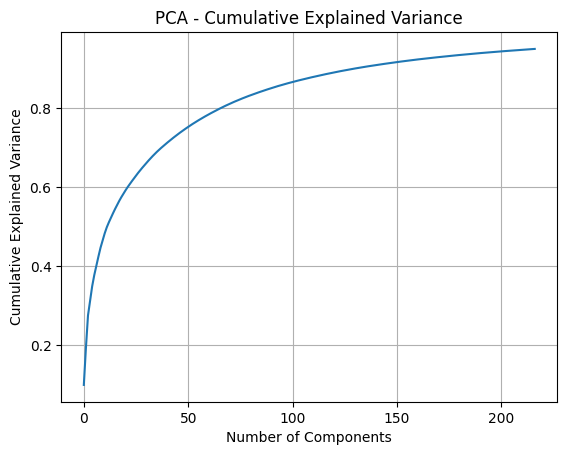

In [ ]:
prep.plot_explained_variance()

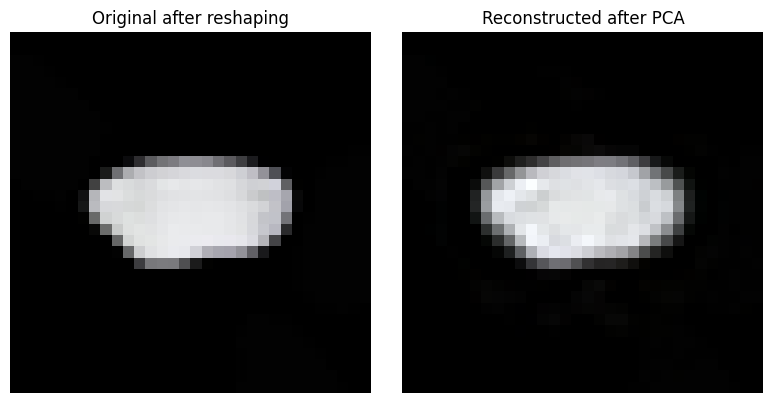

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original after reshaping")
plt.imshow(prep.x_train[0].reshape(32, 32, 3).clip(0, 255).astype(np.uint8))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Reconstructed after PCA")
plt.imshow(prep.reconstruct_image(index=0).clip(0, 255).astype(np.uint8))
plt.axis('off')

plt.tight_layout()
plt.show()

# Machine Learning models implementation

In [ ]:
class ModelEvaluator:
    def __init__(self, x_train, x_test, y_train, y_test, labels):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        self.labels = labels
        self.n_classes = len(labels)

    def evaluate_model(self, model, model_name, save_model=True):
        if os.path.exists(f'{model_name}_model.pkl'):
            with open(f'{model_name}_model.pkl', 'rb') as file:
                model = pickle.load(file)
        else:
            model.fit(self.x_train, self.y_train)
            with open(f'{model_name}_model.pkl', 'wb') as file:
                pickle.dump(model, file)
            print(f'{model_name} model saved!')
        y_pred = model.predict(self.x_test)


        acc = accuracy_score(self.y_test, y_pred)
        print(f"{model_name} Accuracy: {acc:.4f}")


        cm = confusion_matrix(self.y_test, y_pred)
        ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.labels).plot()
        plt.title(f"Confusion Matrix - {model_name}")
        plt.show()

        # Convert true labels to one-hot encoded format (needed for multi-class metrics)
        y_true_bin = label_binarize(self.y_test, classes=list(range(len(self.labels))))
        # Predict class probabilities for test samples
        y_score_probs = model.predict_proba(self.x_test)
        # Calculate mean Average Precision (mAP) across all classes
        ap = average_precision_score(y_true_bin, y_score_probs, average='macro')
        print(f"{model_name} mAP (mean Average Precision): {ap:.4f}")


In [ ]:
evaluator = ModelEvaluator(
    x_train=prep.x_train_pca,
    x_test=prep.x_test_pca,
    y_train=prep.y_train,
    y_test=prep.y_test,
    labels=downloader.data_subfolders
)

## Random Forest

Download RF_model.plk if it is not in colab directory yet

In [ ]:
if not os.path.exists('RF_model.pkl'):
    print('downloading RF')
    rf_file_id = '1zumPYjruGFK8vxreN94dZ-kAmxPJhBYM'
    url = f'https://drive.google.com/uc?id={rf_file_id}'
    gdown.download(url, 'RF_model.pkl', quiet=False)

In [ ]:
rf = RandomForestClassifier(random_state=42)

RF Accuracy: 0.9841


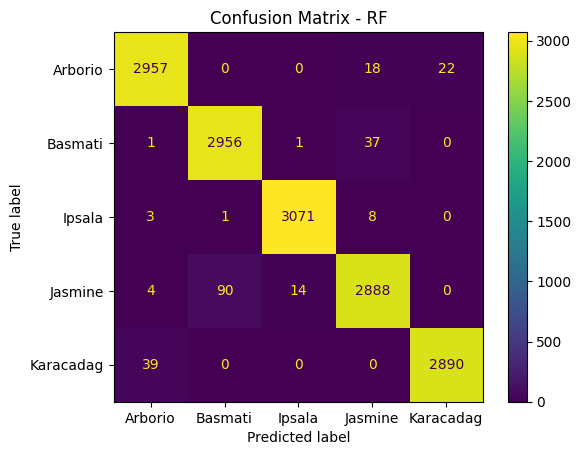

RF mAP (mean Average Precision): 0.9977


In [ ]:
evaluator.evaluate_model(model=rf, model_name="RF")

## KNN

Download KNN_model.plk if it is not in colab directory yet

In [ ]:
if not os.path.exists('KNN_model.pkl'):
    print('downloading KNN')
    knn_file_id = '1G0jLpT8cooNpFxyPMCsLts902VAFuoAE'
    url = f'https://drive.google.com/uc?id={knn_file_id}'
    gdown.download(url, 'KNN_model.pkl', quiet=False)

In [ ]:
knn = KNeighborsClassifier()

KNN Accuracy: 0.9800


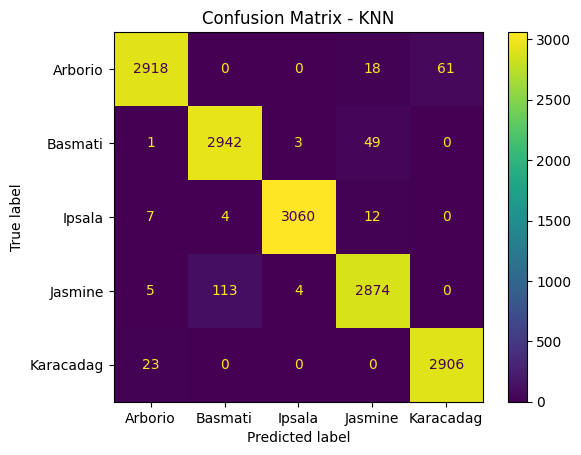

KNN mAP (mean Average Precision): 0.9868


In [ ]:
evaluator.evaluate_model(model=knn, model_name="KNN")

## Logistic Regression

Download Logistic_Regression_model.plk if it is not in colab directory yet

In [ ]:
if not os.path.exists('Logistic_Regression_model.pkl'):
    print('downloading Logistic_Regression')
    lr_file_id = '1-y8xJozq8Cger-ENBj848PTdFm84oNM-'
    url = f'https://drive.google.com/uc?id={lr_file_id}'
    gdown.download(url, 'Logistic_Regression_model.pkl', quiet=False)

In [ ]:
lr = LogisticRegression(max_iter=1000, random_state=42)

Logistic_Regression Accuracy: 0.9847


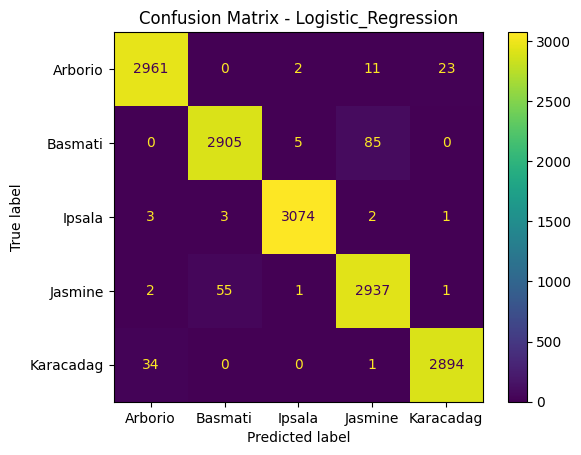

Logistic_Regression mAP (mean Average Precision): 0.9913


In [ ]:
evaluator.evaluate_model(model=lr, model_name="Logistic_Regression")